In [170]:
library(R.utils)
library(keras)  # FashionMNIST dataset
library(nnet)  # Neural networks

# Dataset

We're going to use the Kuzushiji dataset which is a dataset that 
contains 60000 training images and 10000 testing images in grayscale (one 
channel) and of size 28x28. Kuzushiji comes in MNIST original format (packed byte-encoded images), so we need a special function to read it.

In [9]:
gunzip('kuzushiji/train-images-idx3-ubyte.gz')
gunzip('kuzushiji/t10k-images-idx3-ubyte.gz')
gunzip('kuzushiji/train-labels-idx1-ubyte.gz')
gunzip('kuzushiji/t10k-labels-idx1-ubyte.gz')

ERROR: Error in decompressFile.default(filename = filename, ..., ext = ext, FUN = FUN): No such file: kuzushiji/t10k-labels-idx1-ubyte.gz


Now we define some auxiliary functions for loading this dataset.
The dataset comes in a binary form. Details about the format can be found on
Yann LeCun's website http://yann.lecun.com/exdb/mnist/

In [11]:
load_image_file <- function(filename) {
  ret = list()
  f = file(filename,'rb')
  readBin(f,'integer',n=1,size=4,endian='big')
  ret$n = readBin(f,'integer',n=1,size=4,endian='big')
  nrow = readBin(f,'integer',n=1,size=4,endian='big')
  ncol = readBin(f,'integer',n=1,size=4,endian='big')
  x = readBin(f,'integer',n=ret$n*nrow*ncol,size=1,signed=F)
  ret$x = matrix(x, ncol=nrow*ncol, byrow=T)
  close(f)
  ret
}

load_label_file <- function(filename) {
  f = file(filename,'rb')
  readBin(f,'integer',n=1,size=4,endian='big')
  n = readBin(f,'integer',n=1,size=4,endian='big')
  y = readBin(f,'integer',n=n,size=1,signed=F)
  close(f)
  y
}

Loading train and test images

In [12]:
train <- load_image_file('kuzushiji/train-images-idx3-ubyte')
test <- load_image_file('kuzushiji/t10k-images-idx3-ubyte')

Loading labels

In [14]:
train$y <- load_label_file('kuzushiji/train-labels-idx1-ubyte')
test$y <- load_label_file('kuzushiji/t10k-labels-idx1-ubyte') 

We get the following structure:

- train: Training dataset
    + x: the predictors, 28x28 pixels image in grayscale.
    + y: the response
- test: Testing datset (with x and y)

We can see the images with the following function:

In [16]:
str(train)

List of 3
 $ n: int 60000
 $ x: int [1:60000, 1:784] 0 0 0 0 0 0 0 0 0 0 ...
 $ y: int [1:60000] 8 7 0 1 4 2 4 8 1 1 ...


For CNNs we need to have them in 28x28 format instead of an array of 784 pixels

In [19]:
dim(train$x) <- c(dim(train$x)[1], 28,28)

In [21]:
dim(test$x) <- c(dim(test$x)[1], 28,28)

## Response reencode

Notice that in y we have an integer from 0 to 9 (10 classes). They are in fact the following:
- 0: お - o
- 1: き - ki 
- 2: す - su 
- 3: つ - tsu
- 4: な - na
- 5: は - ha
- 6: ま - ma
- 7: や - ya
- 8: れ - re 
- 9: を - wo

We recode the response variable to factor.

In [91]:
classmap <- read.csv("kuzushiji/kmnist_classmap.csv")

In [92]:
classmap$romaji <- c("o","ki","su","tsu","na","ha","ma","ya","re","wo")
classmap

index,codepoint,char,romaji
0,U+304A,お,o
1,U+304D,き,ki
2,U+3059,す,su
3,U+3064,つ,tsu
4,U+306A,な,na
5,U+306F,は,ha
6,U+307E,ま,ma
7,U+3084,や,ya
8,U+308C,れ,re
9,U+3092,を,wo


We use the romaji codification just to prevent problems with UTF8 characters

In [93]:
classString <- classmap$romaji
# y+1 because 0 is the first class and in R we start indexing at 1!
train$yFactor <- as.factor(classString[train$y+1]) 
test$yFactor <- as.factor(classString[test$y+1])

For the CNN we use one hot encoding to produce a vector of 10 values per sample, with a one on the class (probablity of belonging to a given class).

In [94]:
train$yOneHot <- class.ind(train$yFactor)
test$yOneHot <- class.ind(test$yFactor)

*class.ind* reorders the classes alfabetically, therefore we need to revert this order to the original provided. We use *match* over the column names to get a vector of the reorder to match the column names to **classString**.

In [97]:
colnames(train$yOneHot)
classString
(m <- match(classString, colnames(test$yOneHot))) 

[1] "ha"  "ki"  "ma"  "na"  "o"   "re"  "su"  "tsu" "wo"  "ya"

[1] "o"   "ki"  "su"  "tsu" "na"  "ha"  "ma"  "ya"  "re"  "wo"

[1]  5  2  7  8  4  1  3 10  6  9

In [98]:
train$yOneHot <- train$yOneHot[,m]
test$yOneHot <- test$yOneHot[,m]

Now the order is correct

In [99]:
colnames(train$yOneHot)
classString

[1] "o"   "ki"  "su"  "tsu" "na"  "ha"  "ma"  "ya"  "re"  "wo"

[1] "o"   "ki"  "su"  "tsu" "na"  "ha"  "ma"  "ya"  "re"  "wo"

In [100]:
str(train$yOneHot)
train$yFactor[1:10]
train$yOneHot[1:10,]

 num [1:60000, 1:10] 0 0 1 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:10] "o" "ki" "su" "tsu" ...


[1] re ya o  ki na su na re ki ki
Levels: ha ki ma na o re su tsu wo ya

o,ki,su,tsu,na,ha,ma,ya,re,wo
0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0
0,1,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0


## Add missing dimension

Convolutional layers will expect the input to have 4 dimensions:
- Sample dimension
- Height dimension
- Width dimension
- Channel dimension

In our case we have only one channel as the image is grayscale. If it's a color image we would have 3 or 4 channels (Red, Green, Blue and Alpha (transparency)). We need to add the missing dimension, however this will not modify the data. 

In [101]:
dim(train$x) <- c(dim(train$x),1)
dim(test$x) <- c(dim(test$x),1)

## dataset visualization

By the dataset organization, the elements are inverted. Just for display we flip them using `lim = rev(range(0,1))`

In [141]:
rotate <- function(x) apply(x, 2, rev)
show_image <- function(imgarray, col=gray(12:1/12), ...) {
  image((matrix(imgarray, nrow=28)), col=col, ylim = rev(range(0,1)), ...)
}

[1] ha
Levels: ha ki ma na o re su tsu wo ya

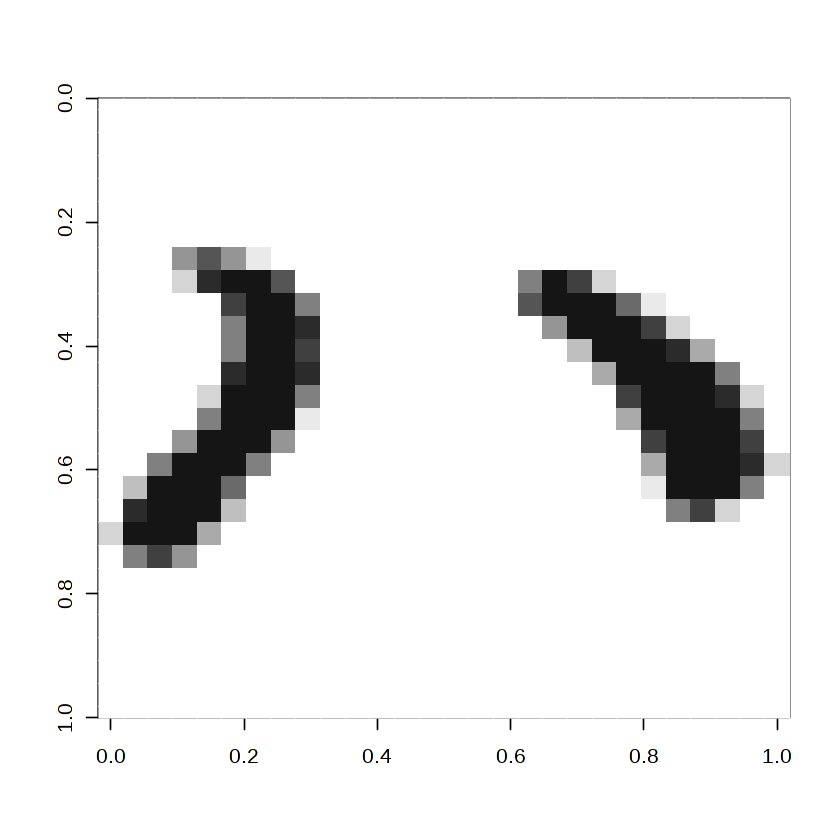

[1] tsu
Levels: ha ki ma na o re su tsu wo ya

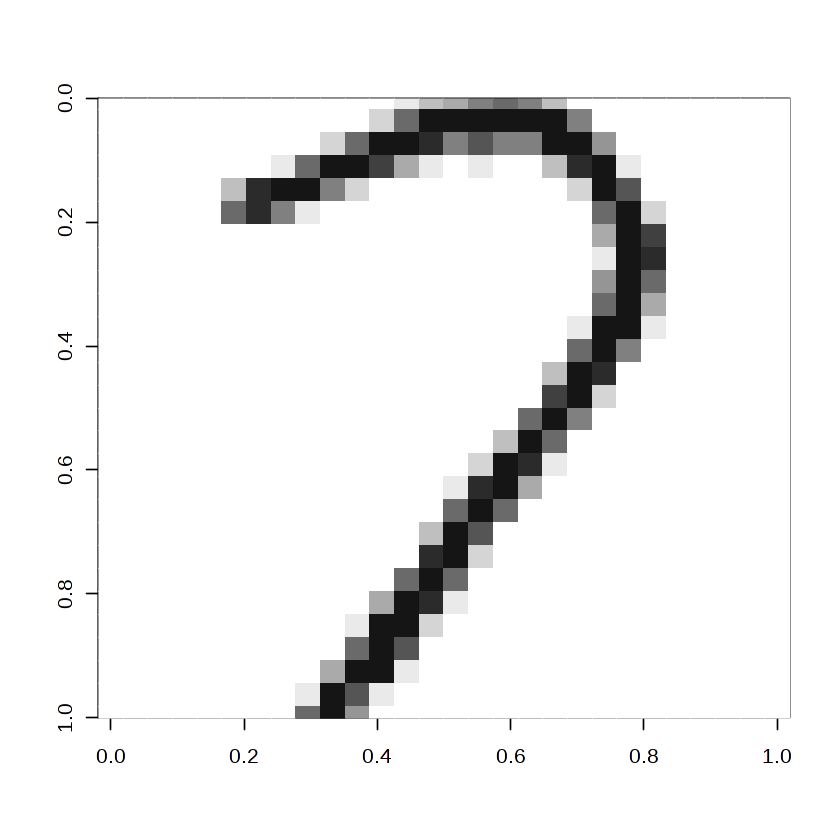

In [149]:
show_image(train$x[14,,,])
train$yFactor[14] # This ha is katakana! ハ
show_image(train$x[416,,,])
train$yFactor[416]

## Create a dataset for nnet

Now we prepare join the X and the Y in a data.frame.

In [150]:
nnetData <- data.frame(train$x, class=train$yFactor)

In [196]:
nnetDataTest <- data.frame(test$x, class=test$yFactor)

# Your code should be here